# Generate student sports data

In [346]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For testing our work
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [347]:
###############################################################################
#                                                                             #
# Settings. By all means change these.                                        #
#                                                                             #
###############################################################################

num_years = 3 # How many years to generate data for?

first_date = '2022-01-01' # What is the first date to generate (yyyy-mm-dd)

holiday_weeks = [52, 1, 8, 18, 42, 27, 28, 29, 30, 31, 32] # Weeks that are considered to be holidays.

first_school_week = 35

exam_weeks = [4, 8, 9] # Weeks that are considered to be exam weeks

week_effect_coefficient = 0.4 # Strength of the weekly effect (school weeks at the start of a block have higher attendance than subsequent weeks)

ny_resolution_coefficient = 0.04 # Strength of the new years resolution effect (higher attendance in january, drops to 0 in june)
baseline_attendance = 100.0 # Should be a float!!


## Generate dates

Include info on holidays and weekdays

In [348]:
df = pd.DataFrame()
df['date'] = pd.date_range(start=first_date, periods=365 * num_years, freq="D")
df['weekday'] = df['date'].dt.weekday
df['weeknum'] = df['date'].dt.isocalendar().week
df['is_holiday'] = df['weeknum'].map(lambda x : True if x in holiday_weeks else False )
df['is_weekday'] = df['weekday'].map(lambda x : True if x in [5, 6] else False)


## Generate school weeks


In [349]:
# Generate a map of week numbers to school weeks
week_school_week_map = {}
for weeknum in range (1, 53):
    week_school_week_map[weeknum] = 0
current_week = first_school_week - 1
current_school_week = 1
while True:
    current_week += 1
    if(current_week in holiday_weeks):
        continue

    week_school_week_map[current_week] = current_school_week
    current_school_week += 1
    if current_school_week > 10:
        current_school_week = 1
    if current_week > 52:
        current_week = 1
    if current_week == first_school_week - 1:
        break
# Hack: it's easier to do this manually (weeks before the start of the schoolyear)
week_school_week_map[33] = 0
week_school_week_map[34] = 0
# And this:
week_school_week_map[53] = 0
week_school_week_map[2] = 7
week_school_week_map[3] = 8
week_school_week_map[4] = 9

df['weeknum'] = df['weeknum'].map(int)
df['school_week'] = df['weeknum'].map(lambda x : week_school_week_map[x + 1])
df.loc[df['is_holiday'], 'school_week'] = 0







## Generate exam info

In [350]:
df['exam_week'] = df.apply(lambda row : True if(row['school_week'] in exam_weeks) else False , axis = 1)


# Generate attendance

Do this for one gym and then copy the data over to multiple gyms (if desired)

In [351]:
df['attendance'] = baseline_attendance

In [352]:
# Add a linear effect to the baseline attendance, but only for non-exam weeks


df['attendance_week_effect'] = df['attendance']
df.loc[df['exam_week'] == False, 'attendance_week_effect'] = df['attendance'] * ((10 - df['school_week']) * 
                                                                                 week_effect_coefficient) + (df['attendance'] * (1 - week_effect_coefficient))



In [353]:
# Add a new year's resolution effect: attendance is highest in january (in non-exam weeks). This effect drops to 0 over 26 weeks
# ny_resolution_coefficient
df['attendance_ny_effect'] = df['attendance_week_effect']
df['ny_mult'] = (abs(df['weeknum'] - 53) - 26)
df['ny_mult'] = df['ny_mult'] * df['ny_mult'] / 26
df.loc[(df['exam_week'] == False) & (df['weeknum'] < 26), 'attendance_ny_effect'] = df['attendance_ny_effect'] * (1 - ny_resolution_coefficient) + df['ny_mult'] * ny_resolution_coefficient * df['attendance_ny_effect']
df
# df.loc[df['exam_week'] == False, 'attendance_week_effect'] = df['attendance_week_effect'] * (1 - ny_resolution_coefficient) + df['attendance_week_effect']
# df

# test = pd.DataFrame()
# test['ding'] = (abs(df['weeknum'] - 53) - 26)
# test['ding'] = test['ding'] * test['ding']
# test['ding'] = test['ding'] / 26
# test['ding'] = test['ding'].clip(0)
# test['ding'].unique()




# * ((10 - df['school_week']) * week_effect_coefficient) + (df['attendance'] * (1 - week_effect_coefficient))

,date,weekday,weeknum,is_holiday,is_weekday,school_week,exam_week,attendance,attendance_week_effect,attendance_ny_effect,ny_mult
0,2022-01-01,5,52,True,True,0,False,100.0,460.0,460.0,24.038462
1,2022-01-02,6,52,True,True,0,False,100.0,460.0,460.0,24.038462
2,2022-01-03,0,1,True,False,0,False,100.0,460.0,920.0,26.000000
3,2022-01-04,1,1,True,False,0,False,100.0,460.0,920.0,26.000000
4,2022-01-05,2,1,True,False,0,False,100.0,460.0,920.0,26.000000
...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,3,52,True,False,0,False,100.0,460.0,460.0,24.038462
1091,2024-12-27,4,52,True,False,0,False,100.0,460.0,460.0,24.038462
1092,2024-12-28,5,52,True,True,0,False,100.0,460.0,460.0,24.038462
1093,2024-12-29,6,52,True,True,0,False,100.0,460.0,460.0,24.038462


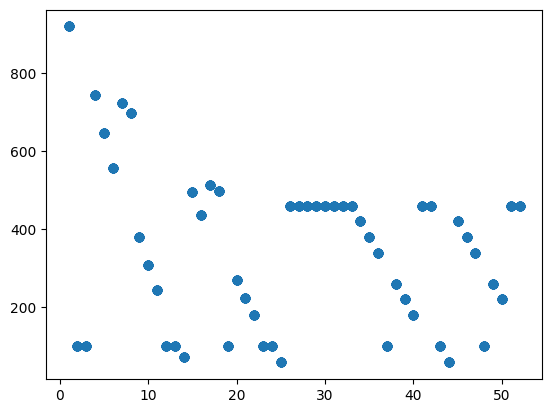

In [354]:
# Check our work
plt.scatter(df['weeknum'], df['attendance_ny_effect'])

In [ ]:
# Generate hourly data
# df['datetime'] = pd.to_datetime(df['date'])
df.set_index('datetime')
df
# df.resample('1h').ffill()

,date,weekday,weeknum,is_holiday,is_weekday,school_week,exam_week,attendance,attendance_week_effect,attendance_ny_effect,ny_mult,datetime
0,2022-01-01,5,52,True,True,0,False,100.0,460.0,460.0,24.038462,2022-01-01
1,2022-01-02,6,52,True,True,0,False,100.0,460.0,460.0,24.038462,2022-01-02
2,2022-01-03,0,1,True,False,0,False,100.0,460.0,920.0,26.000000,2022-01-03
3,2022-01-04,1,1,True,False,0,False,100.0,460.0,920.0,26.000000,2022-01-04
4,2022-01-05,2,1,True,False,0,False,100.0,460.0,920.0,26.000000,2022-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,3,52,True,False,0,False,100.0,460.0,460.0,24.038462,2024-12-26
1091,2024-12-27,4,52,True,False,0,False,100.0,460.0,460.0,24.038462,2024-12-27
1092,2024-12-28,5,52,True,True,0,False,100.0,460.0,460.0,24.038462,2024-12-28
1093,2024-12-29,6,52,True,True,0,False,100.0,460.0,460.0,24.038462,2024-12-29


In [206]:

df[df['school_week'] == 1]

,date,weekday,weeknum,is_holiday,is_weekday,school_week,exam_week,attendance,attendance_week_effect
23,2022-01-24,0,4,False,False,1,False,100,420
24,2022-01-25,1,4,False,False,1,False,100,420
25,2022-01-26,2,4,False,False,1,False,100,420
26,2022-01-27,3,4,False,False,1,False,100,420
27,2022-01-28,4,4,False,False,1,False,100,420
...,...,...,...,...,...,...,...,...,...
1040,2024-11-06,2,45,False,False,1,False,100,420
1041,2024-11-07,3,45,False,False,1,False,100,420
1042,2024-11-08,4,45,False,False,1,False,100,420
1043,2024-11-09,5,45,False,True,1,False,100,420


In [ ]:

# TODO generate hourly data
# TODO apply a linear effect to hourly data, but only for non-exam weeks
# TODO halve the attendance during holidays
# TODO set school week to NaN when it is 0